### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Define ticker names**

In [4]:
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

ticker_list_col = list(pd.read_csv(col_stock_list_path, header=None)[0])
ticker_list_glob = list(pd.read_csv(global_stock_list_path, header=None)[0])

### **Extract data from YFinance**

In [5]:
days_of_data = 7*54*5 + 1
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=days_of_data)

In [6]:
interval = '1wk'  # Uncomment for weekly data
# interval = '1mo' # Uncomment for monthly data

col_stocks_raw = yf.download(ticker_list_col, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']
global_stocks_raw = yf.download(ticker_list_glob, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  37 of 37 completed

3 Failed downloads:
['GXTESCOL.CL', 'NUAMCO.CL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1wk 2019-08-19 -> 2024-10-22)')
['LTMCO.CL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  49 of 49 completed

7 Failed downloads:
['ICHNA.XD', 'ENELAMCO.CL', 'SQMBCO.CL', 'IWVLM.XD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1wk 2019-08-19 -> 2024-10-22)')
['LTMCO', 'IBO1', 'CFMITNIPCO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


### **Preprocessing**

In [7]:
# Assign a frequency to the index of the dataframes
col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly

C:\Users\jumar\AppData\Local\Temp\ipykernel_10404\1577141145.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
C:\Users\jumar\AppData\Local\Temp\ipykernel_10404\1577141145.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly


In [8]:
# Convert from prices into returns
col_rets_raw = col_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')
global_rets_raw = global_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')

C:\Users\jumar\AppData\Local\Temp\ipykernel_10404\3779391522.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  col_rets_raw = col_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')
C:\Users\jumar\AppData\Local\Temp\ipykernel_10404\3779391522.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  global_rets_raw = global_stocks_raw.pct_change().iloc[1:].dropna(axis='columns')


In [9]:
# Merge Col and Global stock prices and returns data
rets = pd.concat([col_rets_raw, global_rets_raw], axis='columns')
stocks = pd.concat([col_stocks_raw, global_stocks_raw], axis='columns')

### **Preprocessing - Analysis of stationarity**

In [10]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ETB.CL series: 0.0
Augmented Dicke

In [11]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

train_rets = rets.iloc[:-36].copy()
val_rets = rets.iloc[-24:-12].copy()
test_rets = rets.iloc[-12:].copy()

### **Initial examination**

In [12]:
# Identify stock pairs with very high correlation

# Generate correlation matrix
corr_mat = train_rets.corr()
# Generate a mask to exclude  duplicated pairs
#mask = np.triu(np.ones_like(corr_mat))
#corr_mat = corr_mat*mask
# Convert the matrix into a dataframe structured as a list of pairs with their respective correlations
stack_corr = pd.DataFrame(corr_mat.stack())
stack_corr = stack_corr[stack_corr[0] < 1]
stack_corr = stack_corr[stack_corr[0] != 0]
stack_corr.index.names = ['Stock 1', 'Stock 2']
stack_corr.reset_index(inplace=True)
#(abs(stack_corr[0]) > .7).sum()

# Filter to visualize only the pairs with very high correlations
high_corrs = stack_corr[stack_corr[0] >= 0.8].sort_values(by=0, ascending=False)
high_corrs

,Stock 1,Stock 2,0
3063,VOO,CSPX.L,0.924251
2144,CSPX.L,VOO,0.924251
1805,BAC,JPM,0.915743
2562,JPM,BAC,0.915743
1265,PFBCOLOM.CL,BCOLOMBIA.CL,0.896307
22,BCOLOMBIA.CL,PFBCOLOM.CL,0.896307
1902,C,BAC,0.871098
1793,BAC,C,0.871098
2564,JPM,C,0.864937
1915,C,JPM,0.864937


In [ ]:
# Explore how some of these variables correlate with the first lag of other variables
correlations = rk.corr_vars_vs_lags(train_rets, n_lags=20)

In [13]:
(correlations['VOO'].iloc[1].sort_values(ascending=True),
 correlations['CSPX.L'].iloc[1].sort_values(ascending=True),
 correlations['JPM'].iloc[1].sort_values(ascending=True),
 correlations['BAC'].iloc[1].sort_values(ascending=True)
)

(F               -0.149765
 MINEROS.CL      -0.109829
 JETS            -0.104971
 BRK-B           -0.102333
 AAPL            -0.096066
 PFGRUPOARG.CL   -0.091615
 ETB.CL          -0.082156
 VOO             -0.075274
 PFGRUPSURA.CL   -0.072599
 JNJ             -0.063721
 EXITO.CL        -0.063243
 PFDAVVNDA.CL    -0.055901
 CELSIA.CL       -0.055194
 JPM             -0.054446
 BOGOTA.CL       -0.050913
 NKE             -0.047955
 CENCOSUD.SN     -0.044145
 GOOGL           -0.042849
 GRUPOAVAL.CL    -0.042029
 C               -0.041932
 LQDA            -0.040485
 ICOLCAP.CL      -0.039276
 CORFICOLCF.CL   -0.030401
 NUTRESA.CL      -0.029853
 CEMARGOS.CL     -0.028935
 GRUPOARGOS.CL   -0.028161
 BCOLOMBIA.CL    -0.022164
 BAC             -0.014336
 GRUBOLIVAR.CL   -0.010415
 SGLD.L          -0.007468
 HCOLSEL.CL      -0.006473
 PFCORFICOL.CL   -0.005390
 ENKA.CL          0.003553
 FALABELLA.SN     0.004986
 CSPX.L           0.005940
 PFBCOLOM.CL      0.008846
 META             0.009775
 

In [52]:
# Identify the stocks with the highest and lowest average correlation with the 1st lag of other stocks
mean_correlations_1st_lag = {}
for var in correlations:
    mean_correlations_1st_lag[var] = abs(correlations[var].iloc[1:5]).mean().mean()
mean_correlations_1st_lag = pd.Series(mean_correlations_1st_lag).sort_values(ascending=False)
mean_correlations_1st_lag

CONCONCRET.CL    0.158247
GRUPOARGOS.CL    0.089852
ECOPETROL.CL     0.089332
JPM              0.080275
BAC              0.079395
C                0.078783
CEMARGOS.CL      0.076681
CHILE.SN         0.073674
JETS             0.072986
CSPX.L           0.072681
PFGRUPOARG.CL    0.072561
F                0.071886
PFCORFICOL.CL    0.070216
BCOLOMBIA.CL     0.069550
JNJ              0.067917
ISA.CL           0.067139
GRUBOLIVAR.CL    0.067132
UBER             0.067054
ICOLCAP.CL       0.067021
EXITO.CL         0.066982
GRUPOSURA.CL     0.065626
META             0.064612
PFBCOLOM.CL      0.064595
PFAVAL.CL        0.064365
CNEC.CL          0.064240
FALABELLA.SN     0.064201
PBR              0.063849
GOOGL            0.063717
MINEROS.CL       0.063702
TERPEL.CL        0.063635
PFGRUPSURA.CL    0.062708
NKE              0.062503
AMZN             0.062243
CBU7.L           0.062194
LQDA             0.060956
VOO              0.060471
HCOLSEL.CL       0.060237
CORFICOLCF.CL    0.059574
EIMI.L      

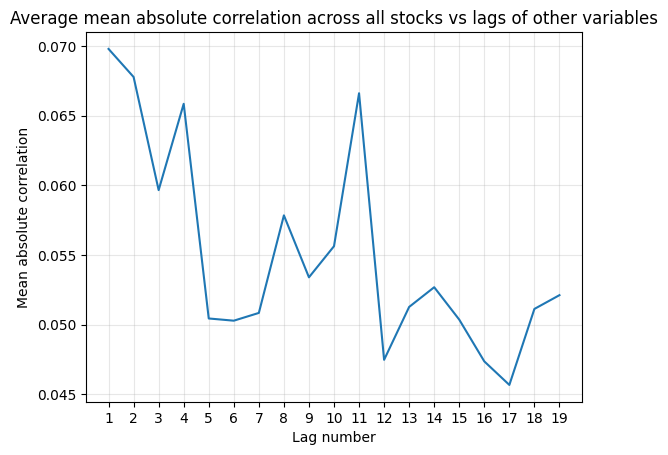

In [101]:
# Identify the number of lags that suggest relevant information across all variables
mean_lags = []
for lag in range(20):
    mean_correlations_n_lag = {}
    for var in correlations:
        mean_correlations_n_lag[var] = abs(correlations[var].iloc[lag]).mean().mean()
    mean_lags.append(pd.Series(mean_correlations_n_lag))
mean_lags = pd.concat(mean_lags, axis=1).mean(0)

# Visualize the results
mean_lags.iloc[1:].plot()
plt.grid(alpha=.3)
plt.title('Average mean absolute correlation across all stocks vs lags of other variables')
plt.ylabel('Mean absolute correlation')
plt.xlabel('Lag number')
plt.xticks(np.arange(1, 20))
plt.show()

In [82]:
# Choose the variables with highest absolute correlation with lags 1-11 of other variables
mean_correlations_n_lag = {}
for var in correlations:
    mean_correlations_n_lag[var] = abs(correlations[var].iloc[:12]).mean().mean()
mean_correlations_n_lag = pd.Series(mean_correlations_n_lag).sort_values(ascending=False)
mean_correlations_n_lag

JETS             0.096313
C                0.095662
JPM              0.093172
BAC              0.090862
BCOLOMBIA.CL     0.090484
PFBCOLOM.CL      0.090175
ECOPETROL.CL     0.090077
ICOLCAP.CL       0.089393
BRK-B            0.088205
CONCONCRET.CL    0.087910
CSPX.L           0.087904
PBR              0.086439
F                0.086350
VOO              0.085103
GRUPOARGOS.CL    0.084136
PFAVAL.CL        0.083617
EIMI.L           0.083073
PFDAVVNDA.CL     0.082980
GE               0.082521
HCOLSEL.CL       0.082069
PFGRUPOARG.CL    0.081784
UBER             0.078809
CEMARGOS.CL      0.078662
CORFICOLCF.CL    0.078603
FALABELLA.SN     0.078600
PFGRUPSURA.CL    0.078306
PFCORFICOL.CL    0.077569
NKE              0.077041
ISA.CL           0.075983
JNJ              0.074972
GRUPOSURA.CL     0.073932
MINEROS.CL       0.072637
GOOGL            0.072441
GRUBOLIVAR.CL    0.070915
GRUPOAVAL.CL     0.070672
AAPL             0.070586
META             0.070303
CENCOSUD.SN      0.069943
CHILE.SN    

In [85]:
# Let's build the model based on the top 15 stocks with highest correlation agains lags of other stocks
top15 = mean_correlations_n_lag.index[:15]

# Update the train and test sets to focus on the selected group of stocks
train_rets = train_rets[top15]
val_rets = val_rets[top15]
test_rets = test_rets[top15]

### **Estimate parameters for the VAR model**

In [110]:
# Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
varmod = VAR(train_rets)
lag_sel = varmod.select_order(13)
print(lag_sel.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -101.6     -101.4*   7.172e-45     -101.6*
1       -102.6      -98.93  2.719e-45*      -101.1
2       -102.5      -95.38   3.033e-45      -99.65
3       -102.4      -91.79   3.695e-45      -98.12
4       -102.2      -88.11   5.260e-45      -96.50
5       -101.6      -84.06   1.182e-44      -94.51
6       -101.7      -80.71   1.487e-44      -93.22
7       -102.0      -77.58   1.776e-44      -92.15
8       -102.5      -74.57   2.361e-44      -91.21
9       -103.3      -71.98   2.801e-44      -90.68
10      -104.7      -69.85   3.286e-44      -90.62
11      -106.6      -68.35   4.109e-44      -91.17
12      -110.3      -68.53   2.956e-44      -93.42
13     -116.2*      -70.96   2.125e-44      -97.91
--------------------------------------------------


In [114]:
# Results of AIC for multiple VAR estimations suggest that 13 lags contain useful information for the 15 stocks selected
var_13l = VAR(train_rets).fit(maxlags=13, trend='c')
print(var_13l.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Oct, 2024
Time:                     14:58:46
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                   -70.9603
Nobs:                     221.000    HQIC:                  -97.9132
Log likelihood:           11072.6    FPE:                2.12527e-44
AIC:                     -116.167    Det(Omega_mle):     1.55330e-48
--------------------------------------------------------------------
Results for equation JETS
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.010174         0.015671           -0.649           0.516
L1.JETS                  -0.169333         0.393315           -0.431           0.667
L1.C                      0.464152         0.

In [119]:
# Test for absence of significant residual autocorrelations
test_corr = var_13l.test_whiteness(nlags=14, signif=0.05, adjusted=False)
# There is no serial autocorrelation in residuals if p-value is more than 0.05
test_corr.pvalue

np.float64(0.0)

In [130]:
# Check if the VAR model is stable
stest = var_13l.is_stable()
# The model is stable if the result is True
stest

np.False_